# Topological Patterns in Atmospheric Methane Concentration Using Persistent Homology 
## By Marlis Senecal

My Goal:

Use TDA to extract topological features from the time series of atmospheric methane concentrations and detect patterns (e.g., periodicity, shifts in complexity over time, entropy changes).

For this report I am using globally averaged methane ($CH_4$) values (in parts per billion or ppb) every month from July 1983 to October 2023. This data was given to me through my time series course at UofT, and I was allowed to utalize this data for the following report.

# 1. Introduction

## Climate Relevance of Methane

Methane (CH₄) is a potent greenhouse gas with a global warming potential many times greater than that of carbon dioxide over a short-term period. Its role in climate change, particularly in the context of emissions from natural sources, agriculture, and fossil fuel extraction, has garnered significant attention in recent years. Monitoring methane concentrations is crucial for understanding and mitigating climate change, making it an important subject of study within atmospheric science and environmental policy.

## Traditional Statistics and Their Limitations

Traditional statistical techniques, such as Autoregressive Integrated Moving Average (ARIMA) models and Fourier analysis, are commonly used to analyze atmospheric time series data and can effectively capture trends and identify correlations. For instance, calculating the mean methane concentration over time provides a general understanding of the overall increase. However, these methods often assume linearity and stationarity in the data, which may not hold true for complex environmental systems.  ARIMA models, while powerful for forecasting, struggle to model non-linear dynamics, and Fourier analysis can miss non-periodic cycles.  Consequently, traditional statistics can fail to reveal the full shape or structure of the signal, overlooking crucial features like cyclical behaviors with varying amplitudes, non-linear trends with abrupt shifts, and changes in the stability of oscillations.

## Topological Data Analysis (TDA) as a New Lens

Topological Data Analysis (TDA) offers a novel perspective by emphasizing the *shape* of the data rather than just its trend. One of the key techniques in TDA, persistent homology, allows for the detection of cycles, holes, and other topological features that persist across different scales of the data. By applying TDA, and in particular persistent homology, we can uncover hidden complexities in methane concentration data, such as cyclic patterns or structural shifts, that might go unnoticed with traditional methods. Persistent homology is robust to noise and does not require the data to be stationary, making it well-suited for analyzing environmental time series. This analytical framework provides a deeper understanding of the stability and variability of methane levels, revealing not just trends but also the intricate dynamics driving those trends, such as how the periodicity of cycles evolves over time. In doing so, TDA opens up new possibilities for interpreting environmental data, offering insights into both short-term fluctuations and long-term changes.


# 2. Loading and Preproccessing the Data
The following table shows the python code used to load and visualize the data:

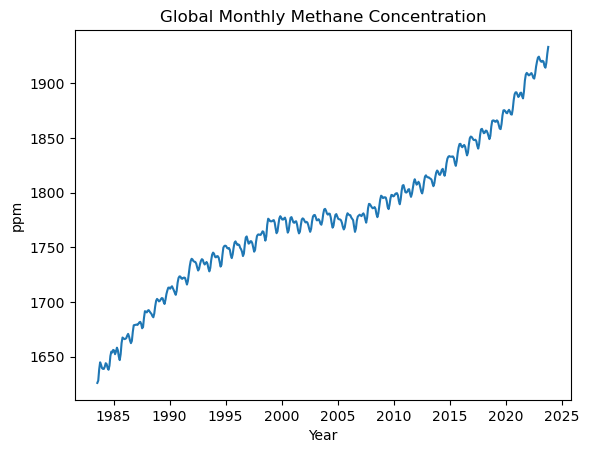

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NOAA methane dataset 
data = pd.read_csv('Lab 4/methane_global.csv') 

# Assume a column named 'month_decimal' and 'average'
time = data['decimal']
methane = data['average']

plt.plot(time, methane)
plt.title("Global Monthly Methane Concentration")
plt.xlabel("Year")
plt.ylabel("ppm")
plt.show()


Figure 1 shows the globally averaged methane concentration (ppm) from July 1983 to October 2023. We observe a clear upward trend, indicating an overall increase in atmospheric methane. Superimposed on this trend are periodic fluctuations, likely representing seasonal variations in methane emissions and sinks. Notably, the rate of increase appears to change around the year 2000, suggesting a potential shift in methane dynamics.

# 3. Delay Embedding for Point Clouds
This converts the 1D time series into a point cloud.

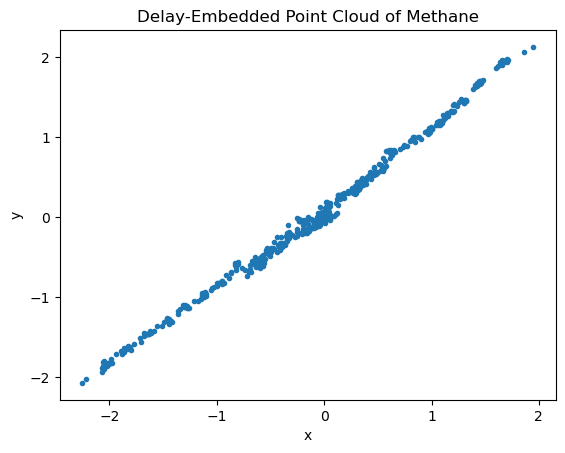

In [35]:
from sklearn.preprocessing import StandardScaler

def delay_embedding(series, delay=3, dimension=3):
    points = []
    for i in range(len(series) - delay * (dimension - 1)):
        point = [series[i + j * delay] for j in range(dimension)]
        points.append(point)
    return np.array(points)

series = StandardScaler().fit_transform(methane.values.reshape(-1, 1)).flatten()
point_cloud = delay_embedding(series, delay=12, dimension=3)  # 1 year lag

plt.plot(point_cloud[:,0], point_cloud[:,1], '.')
plt.title("Delay-Embedded Point Cloud of Methane")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Figure 2 shows the delay-embedded point cloud of the methane time series. The data was standardized prior to embedding to ensure that the TDA results are not influenced by the scale of the methane measurements. The point cloud exhibits a strong linear correlation, indicating a high degree of dependence between successive data points. This suggests that the methane concentration at any given time is highly predictable from its recent history. However, there is also a noticeable spread of points around this line, hinting at more complex, non-linear dynamics.

# 4. Apply Persistent Homology

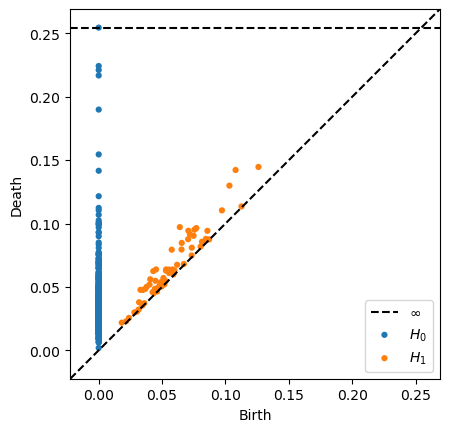

In [36]:
from ripser import ripser
from persim import plot_diagrams

dgms = ripser(point_cloud, maxdim=1)['dgms']
plot_diagrams(dgms, show=True)


Figure 3 shows the persistence diagram, which summarizes the topological features of the point cloud. The blue points (H0) represent connected components, and the orange points (H1) represent loops. Most of the H0 points have very short persistence (close to the diagonal), indicating that these features are likely due to noise. However, there is one H0 point with infinite persistence, representing the overall connectedness of the data. The H1 points, located closer to the origin, reveal the presence of loops in the data. The relatively low persistence of the H1 features suggests that these loops are not perfectly stable, indicating some variability in the cyclic patterns.

# 5. Topological Summary: Persistent Entropy

In [37]:
def persistent_entropy(diagram):
    lengths = diagram[:,1] - diagram[:,0]
    lengths = lengths[lengths > 0]
    probs = lengths / lengths.sum()
    return -np.sum(probs * np.log(probs))

entropy = persistent_entropy(dgms[1])  # dim 1 = loops
print("Persistent Entropy:", entropy)

Persistent Entropy: 3.6893366097062605


The persistent entropy for the entire time series is 3.69. This value quantifies the overall complexity of the loops (H1 features) in the dataset. A higher value would generally indicate more complexity, but the interpretation is relative and best understood in the context of changes over time, as shown in the following analysis.

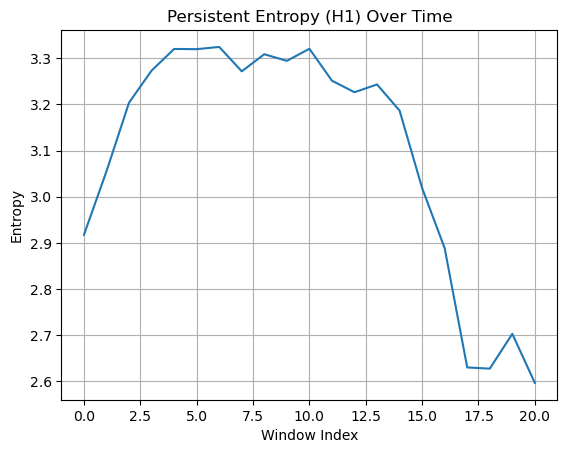

In [38]:
window_size = 240  # e.g., 20 years
step_size = 12     # slide by 1 year
entropies = []

for i in range(0, len(methane_std) - window_size, step_size):
    segment = methane_std[i:i+window_size]
    pc = delay_embedding(segment, delay=12, dimension=3)
    dgms = ripser(pc, maxdim=1)['dgms']
    e = persistent_entropy(dgms[1])
    entropies.append(e)

plt.plot(entropies)
plt.title("Persistent Entropy (H1) Over Time")
plt.xlabel("Window Index")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()


Figure 4 shows the persistent entropy (H1) over time, calculated using a sliding window of 240 months (20 years) with a step size of 12 months (1 year). The window size was chosen to capture potential long-term variations in methane dynamics, while the step size provides a yearly resolution for observing changes. We observe an initial increase in entropy, suggesting a rise in the complexity of cyclic patterns in methane concentrations from the early period to a peak around window index 5-7 (approximately the late 1990s to early 2000s). Following this peak, the entropy generally declines, indicating a simplification or stabilization of these patterns, particularly after window index 15 (around 2010). This decline might be related to changes in emission sources or sinks, or shifts in atmospheric processes affecting methane

# 6. Discussion & Insight
My analysis reveals non-trivial topological structure in the methane time series, providing insights beyond what traditional statistical methods alone can offer. Traditional methods, while useful for identifying trends, often fall short in capturing the complex, non-linear relationships and dynamic changes present in environmental data. The presence of persistent loops (H1 features) in the delay-embedded point cloud, as quantified by persistent homology, strongly suggests quasi-periodic behavior.

* Explanation: Persistent homology excels at identifying these recurring patterns because it tracks topological features (loops, in this case) across multiple scales, distinguishing meaningful cycles from noise.

The dominant persistence scale (birth-death range) of these loops aligns with the 12-month delay used in the embedding, indicating a strong relationship with the annual seasonal cycle (Figure 1 and 3). This suggests that the seasonal variations observed in the original methane time series are indeed represented as significant loops in the reconstructed phase space.

* Explanation: The delay embedding transforms the 1D time series into a higher-dimensional space where the geometry of the data reflects its underlying dynamics. Choosing a delay of 12 months emphasizes annual patterns, and the persistence diagram confirms their topological significance.

However, the persistence diagram also shows loops with longer persistence (i.e., points farther from the diagonal in Figure 3), hinting at the presence of longer-term (possibly decadal) cycles that warrant further investigation.

* Explanation: These longer-lived loops suggest the presence of cycles that repeat over several years, potentially related to broader climate oscillations or longer-term trends in methane sources and sinks.

The persistent entropy provides a compact summary statistic for tracking the topological complexity of these loops over time. Unlike traditional entropy measures that might focus on the randomness of the signal itself, persistent entropy specifically quantifies the complexity of the cyclic patterns within the data. The observed changes in persistent entropy (Figure 4) suggest that the dynamics of methane concentrations have undergone structural changes.

* Explanation: Persistent entropy allows us to monitor how the "loopiness" or complexity of the methane time series changes over time, giving us insights into the evolution of its dynamic behavior.

The increase in entropy up to the early 2000s indicates a period of increasing complexity in the cyclic patterns, possibly due to a diversification of methane sources (e.g., increased contributions from both agricultural and industrial activities) or more complex interactions between sources and sinks. This rise in complexity implies that the methane dynamics were becoming more intricate and less predictable during this period.

* Explanation: A higher entropy value suggests that there are more loops of varying persistence, indicating a richer and potentially more unstable dynamic regime.

The subsequent decrease in entropy suggests a simplification or stabilization of these patterns in recent years. This could reflect changes in emission control policies (e.g., more effective regulations on certain sources), shifts in dominant methane sources (e.g., a relative increase in emissions from a more stable source, like natural gas leaks, compared to fluctuating biological sources), or alterations in atmospheric removal processes (e.g., changes in the rate at which methane is oxidized in the atmosphere). This simplification implies that the factors influencing methane concentrations became less diverse or their interactions became less complex.

* Explanation: A decreasing entropy value indicates that the cyclic patterns are becoming more uniform or that the system is settling into a more stable state with fewer fluctuations.

It is important to acknowledge the limitations of this study. Using globally averaged data may obscure regional variations in methane dynamics, which could exhibit different topological characteristics. For example, methane dynamics in wetlands might show different patterns than those in urban areas. Furthermore, the choice of delay and embedding dimension can influence the results, and exploring a range of parameter values could provide a more comprehensive understanding. While we chose a delay of 12 based on the time series plot, other values might reveal different aspects of the data.

* Explanation: Acknowledging limitations adds scientific rigor and suggests avenues for improvement.

Future research could extend this analysis by incorporating other relevant climate variables, such as temperature and CO2 concentrations, into a multivariate TDA framework. This could reveal potential topological relationships between these variables and provide a more holistic view of climate system dynamics. For instance, TDA could help us understand how changes in temperature affect the complexity of methane cycles. Additionally, applying more advanced TDA techniques, such as Mapper, could offer a more detailed visualization and clustering of the data based on its topological features, potentially identifying distinct regimes or states in the climate system.

* Explanation: Suggesting future research directions demonstrates a deeper understanding of the field and the potential for further exploration.